In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import ase
import numpy as np
import ase.io as aio

from toolz.curried import pipe, curry, compose

In [3]:
import filters
import stats as astat
import utilities as utils

In [4]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [5]:
from ase import Atoms 
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())

runs = np.loadtxt("runs.txt").astype(int)

## Estimate Distrubance in 3D

In our use of both two point statistics and rdf, we first extract atoms that constitute the substructure of interest (e.g. cascade or grain boundary) - then utilize either of these two metrics to aggregate the local environment around all the atoms constituting the substructure.

* Load coordinates of all atoms in 'coords_all'
* Load coordinates of disturbed atom in 'coords_sub' 
    * (They can be computed using ovito - Common Neighbour Analysis and saved in an xyz file )
* The xyz file if available can be read with ase usin the following code snippet:

         atom = aio.read("file_name.xyz")
         coords = atom.get_positions()

### When computing for damaged structures, atoms corresponding to the damaged region are considered.

In [34]:
cutoff = 17.0
r_stat = 15.0
len_pixel = 10.0 

## Perfect Strucure

In [64]:
%%time
ix=-1
from ase.build import bulk
atoms = bulk('Cu', 'fcc', a=3.6, cubic=True).repeat([20]*3)

np.random.seed(81396)
idx = np.random.randint(low=0, high=len(atoms), size=500)

coords_all = atoms.get_positions()
coords_sub = coords_all[idx]

tree = astat.get_kdTree(atoms.get_positions(), 
              cell_dim=atoms.get_cell_lengths_and_angles(), 
             cutoff=cutoff 
             )

indexes = tree.search_tree(coords_sub, radius=r_stat)

CPU times: user 3.72 s, sys: 150 ms, total: 3.87 s
Wall time: 1.31 s


## Thermalized Structure

In [80]:
%%time
ix=0
atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
             lambda f: utils.load_file(f), 
             lambda a: get_atoms(a))

idx = np.where(atoms.get_tags() != 1)[0]
print("total atoms: {}, disturbed atoms: {}".format(len(atoms), len(idx)))

if len(idx) == 0:
    np.random.seed(81396)
    idx = np.random.randint(low=0, high=len(atoms), size=10000)

coords_all = atoms.get_positions()
coords_sub = coords_all[idx]

obj = utils.load_file("data/stat_indxs_cutoff_150/dump.arc.{}_stat.pkl".format(runs[ix]))
indexes = obj["indexes"]

total atoms: 4000000, disturbed atoms: 0
CPU times: user 7.09 s, sys: 630 ms, total: 7.72 s
Wall time: 1.28 s


## Damaged Structure

In [92]:
%%time
ix=1
atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
             lambda f: utils.load_file(f), 
             lambda a: get_atoms(a))

idx = np.where(atoms.get_tags() != 1)[0]
print("total atoms: {}, disturbed atoms: {}".format(len(atoms), len(idx)))

if len(idx) == 0:
    np.random.seed(81396)
    idx = np.random.randint(low=0, high=len(atoms), size=2000)

coords_all = atoms.get_positions()
coords_sub = coords_all[idx]

obj = utils.load_file("data/stat_indxs_cutoff_150/dump.arc.{}_stat.pkl".format(runs[ix]))
indexes = obj["indexes"]

total atoms: 4000000, disturbed atoms: 87589
CPU times: user 7.44 s, sys: 1.43 s, total: 8.87 s
Wall time: 2.55 s


## load real space stat coordinates

In [93]:
%%time
coords_stat = astat.get_realStats(coords_all, coords_sub, indexes, r_stat=r_stat, 
                            cell=atoms.get_cell(), 
                            pbc=atoms.get_pbc())

CPU times: user 25.1 s, sys: 3.8 s, total: 28.9 s
Wall time: 12.6 s


## Compute RDF

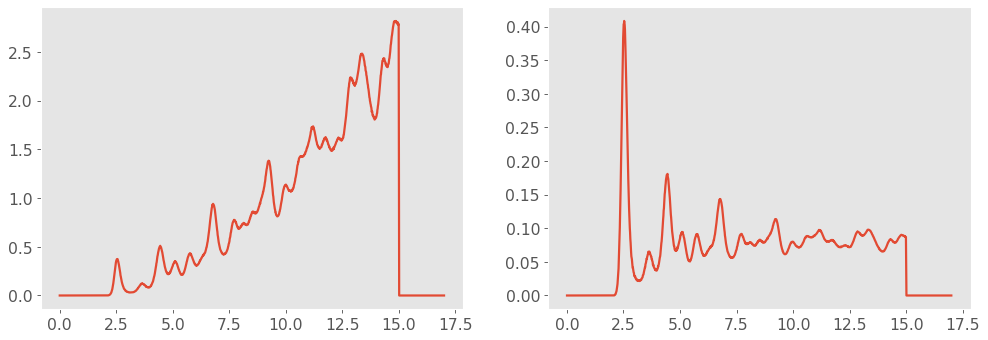

CPU times: user 13.5 s, sys: 1.12 s, total: 14.6 s
Wall time: 7.06 s


In [94]:
%%time
rdf, pdf, bin_centers = astat.get_rdf(coords_stat, r_stat, len_pixel*10)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))
axs[0].plot(bin_centers, rdf)
axs[1].plot(bin_centers, pdf)

for ax in axs:
    # Hide grid lines
    ax.grid(False)
    # Hide axes ticks
#     ax.set_xticks([])
#     ax.set_yticks([])
plt.show()

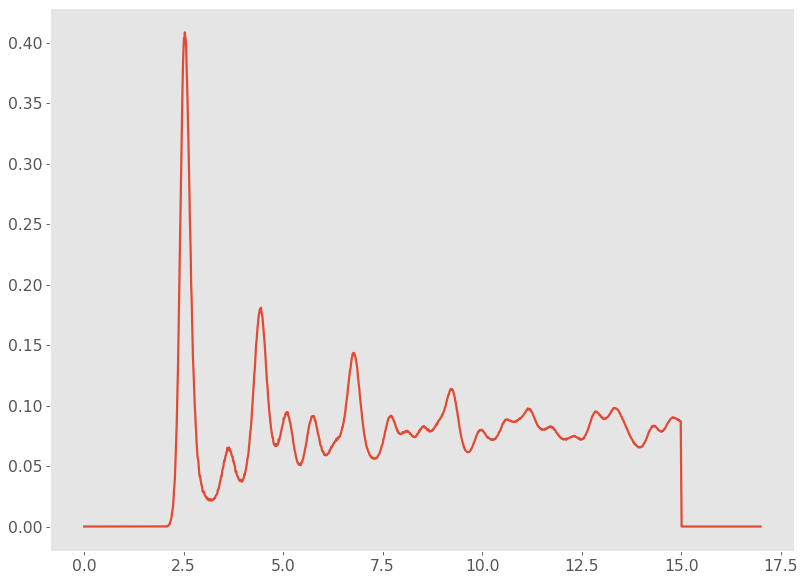

In [95]:
plt.plot(bin_centers, pdf)
plt.grid(b=None)
plt.show()

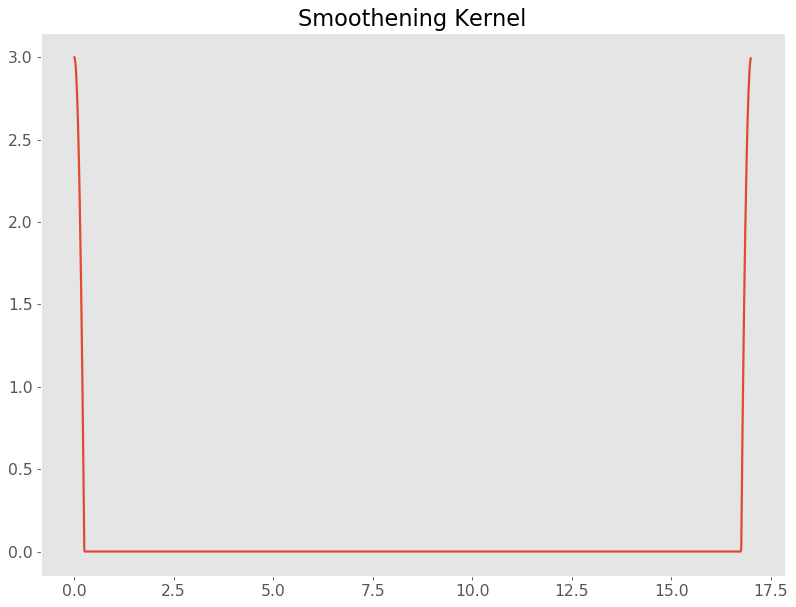

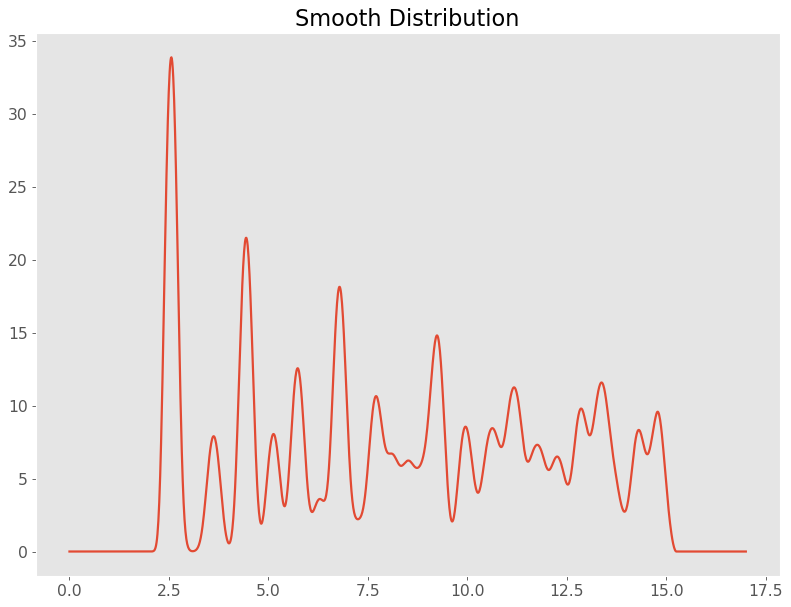

In [84]:
kernel = filters.epanechnikov_kernel(width=0.25, x=bin_centers)

plt.plot(bin_centers, kernel)
plt.title("Smoothening Kernel")
plt.grid(b=None)
plt.show()

new_pdf = filters.convolve_kernel(kernel, pdf)

plt.plot(bin_centers, new_pdf)
plt.title("Smooth Distribution")
plt.grid(b=None)
plt.show()



### Compute the vector counts and save them in a matrix called box

In [102]:
%%time
box = astat.get_2ptStat(coords_stat, r_stat, len_pixel)
print("shape of the stat box: {}".format(box.shape))

shape of the stat box: (301, 301, 301)
CPU times: user 10.3 s, sys: 2.42 s, total: 12.7 s
Wall time: 5.86 s


### Visualize the vector counts

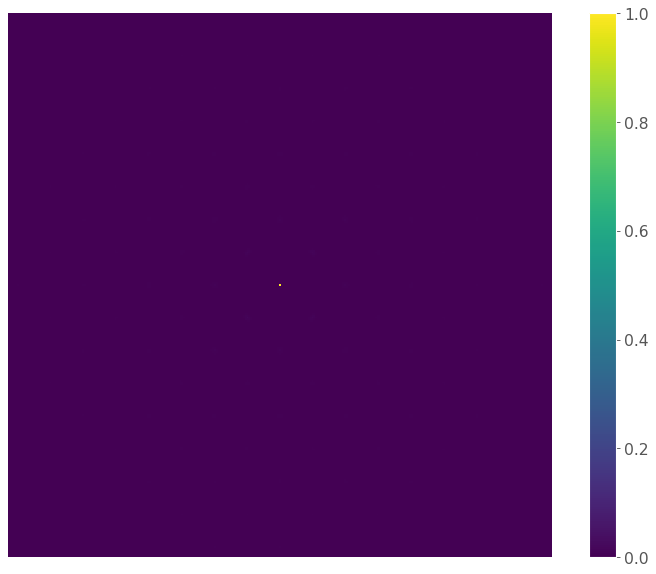

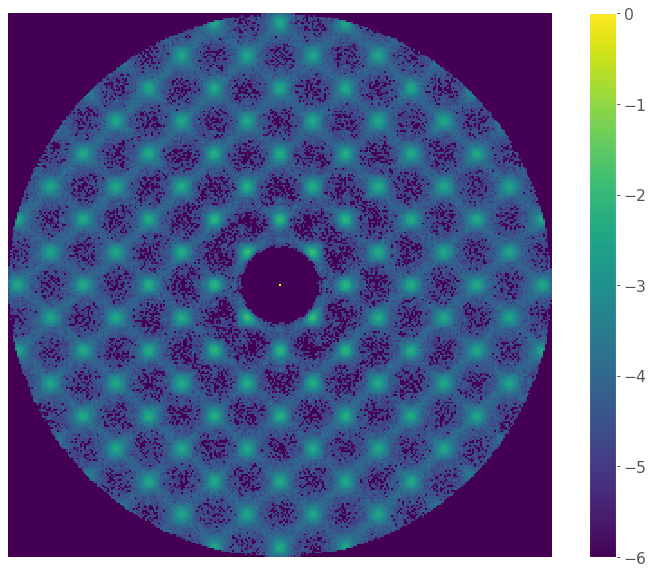

In [103]:
idx = int(r_stat * len_pixel)
utils.draw_im(box[:,:, idx])
utils.draw_im(np.log10(box[:,:,idx]+1e-6))

### Compute a smoothening filter for two point statistics

In [104]:
r_s = 1.0 # radius of the smoothening filter
new_shape = np.asarray(box.shape) + int(2 * r_s * len_pixel)

fs = pipe(r_s, 
          lambda r_s: filters.sphere(r_s * len_pixel),
          lambda s: utils.padder(s, new_shape), 
          lambda s: filters.imfilter(arg1=s, arg2=s) / np.count_nonzero(s))

### Visualize the smoothening filter

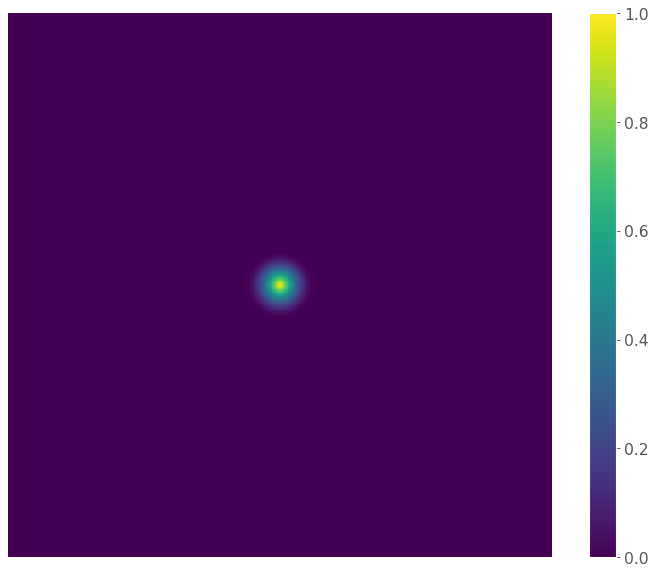

In [105]:
idx = int((r_stat + r_s) * len_pixel)
utils.draw_im((fs[:,:, idx]))

## Apply the smoothening filter to the box

In [108]:
%%time
box1 = pipe(box, 
            lambda s: utils.padder(s, new_shape), 
            lambda s: filters.imfilter(arg1=s, arg2=fs))

CPU times: user 8.78 s, sys: 882 ms, total: 9.66 s
Wall time: 699 ms


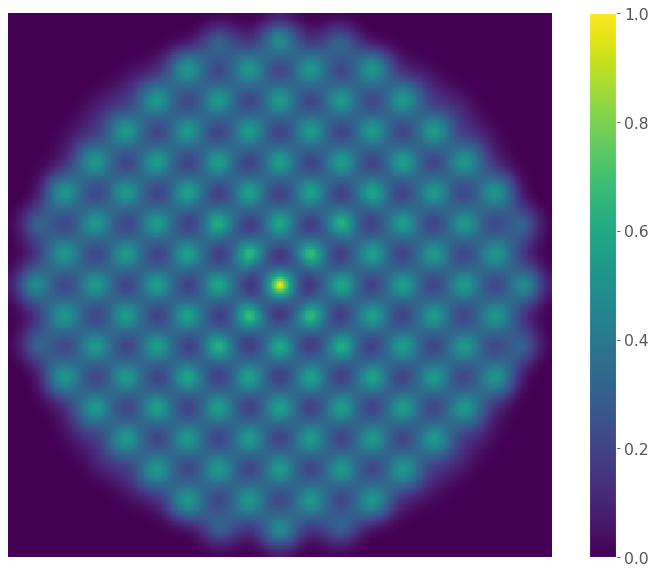

In [109]:
idx = int((r_stat + r_s) * len_pixel)
utils.draw_im(box1[:,:,idx])